In [1]:
import pandas as pd
import numpy as np

In [248]:
import src.roberta as rob

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [216]:
quizzes = {"week2": "Quiz 1",
           "week3": "Quiz 2",
           "week4": "Quiz 3",
           "week5": None,
           "week6": "Quiz 4",
           "week7": "Quiz 5",
           "week8": None}

In [288]:
df = pd.read_csv("data/anonymized_results.csv")

In [289]:
for col in df.columns:
    if list(np.unique(df[col].astype(str))) == ["-"]:
        df.drop(columns=[col], inplace=True)

In [290]:
len(df)

282

In [212]:
np.unique(df["Quiz:Quiz 7 (Real)"])

KeyError: 'Quiz:Quiz 7 (Real)'

In [4]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
type(model)

transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification

In [44]:
new_model = model.base_model

In [47]:
new_model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [96]:
def get_768_features(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = new_model(**encoded_input)
    scores = output[0][0].detach().numpy()
    return scores[0]

In [60]:
encoded_input = tokenizer("Hello world, this is a strange text without brackets", return_tensors='pt')

In [62]:
output = new_model(**encoded_input)

In [67]:
output[0][0].shape

torch.Size([12, 768])

In [95]:
output[0][0][0].shape

torch.Size([768])

In [ ]:
# Try claster 0
# Try claster avg

In [293]:
target = pd.DataFrame()
dump = pd.DataFrame()

for k, v in quizzes.items():
    if not v is None:
        col = [i for i in df.columns if v in i][0]
        df.loc[df[col] == "-",col] = '0'
        target[f"{k}_quiz"] = df[col] 

for week_n in range(2, 9):
    target[f"week{week_n}_text"] = [""] * len(df)
    for col in df.columns:
        #if f"week{week_n}" in col:
        if (f"week{week_n}" in col) and (("Last question" in col) or ("most challenging" in col)):
            if len(df.groupby([col]).size()) <= 10:
                continue
            dump[col] = df[col]
            dump.loc[dump[col].astype(str).str.len() < 5,col] = ""
            dump.fillna("", inplace=True)
            target[f"week{week_n}_text"] += " " + dump[col].astype(str)
        
        if f"LA0{week_n}" in col:
            target[col] = df[col]



In [295]:
cur_cols = [i for i in target.columns if "text" in i]
for col in cur_cols[:2]:
    #target = target[target[col].str.len() > 2]
    num = col[4]
    list_col = [str(i) for i in target[col]]
    lengths = [len(i) for i in list_col]
    print(min(lengths), max(lengths), sum(lengths)/len(lengths))
    print("Cutted", len([i for i in lengths if i > 500]))
    list_col = [i[-500:] for i in list_col]
    target[f"week{num}_embeding"] = [get_768_features(i) for i in list_col]
    target[f"week{num}_santiment"] = rob.get_scores_for(list_col)

    #See how they came - neg, neu, pos
target.head()


2 4838 162.1241134751773
Cutted 12
2 1367 107.01418439716312
Cutted 7


,week2_quiz,week3_quiz,week4_quiz,week6_quiz,week7_quiz,week2_text,LA02 (Real),week3_text,LA03 (Real),week4_text,...,week6_text,LA06 (combined) total (Real),week7_text,LA07 (Real),week8_text,LA08 total (Real),week2_embeding,week2_santiment,week3_embeding,week3_santiment
0,6.13,11.0,6.0,16.0,9.0,,83.87,,100.0,,...,,80.00,,100.0,,0.0,"[-0.19054419, -0.1539861, -0.004027374, -0.348...","[0.22382927, 0.5498368, 0.22633386]","[-0.19054419, -0.1539861, -0.004027374, -0.348...","[0.22382927, 0.5498368, 0.22633386]"
1,7.0,10.0,5.0,13.0,7.0,"The whole 'return' and '__name__ == ""__main__...",100.0,I don't think there was necessarily an exampl...,100.0,,...,None:),80.00,"No, it is no longer challenging",71.43,,0.0,"[-0.16863042, -0.45048615, 0.19275849, -0.8559...","[0.94230413, 0.0519551, 0.005740964]","[-0.1801885, -0.047691412, 0.093483225, -0.574...","[0.52830076, 0.3840897, 0.087609656]"
2,7.0,10.0,6.0,12.0,9.0,Really enjoying the class so far.,100.0,"Binary, it just seems difficult to understand...",100.0,,...,None.,92.08,That week's material was clear,100.0,,0.0,"[0.22504117, 1.7043875, -0.5477258, -0.3081236...","[0.002098508, 0.015788857, 0.9821127]","[-0.21633385, 0.08302394, -0.060284074, -0.401...","[0.3588995, 0.48714393, 0.15395655]"
3,0,8.0,0,13.0,4.0,,66.13,The most challenging lab for me was 3.15. I b...,97.06,,...,,0.00,,71.43,,0.0,"[-0.19054419, -0.1539861, -0.004027374, -0.348...","[0.22382927, 0.5498368, 0.22633386]","[-0.0878651, -0.23522758, 0.2718577, -0.547868...","[0.82052815, 0.15655486, 0.022917029]"
4,6.13,9.0,7.0,14.0,8.0,,100.0,no thoughts behind these eyes,97.06,,...,,85.00,I didn't submit Week 3 Reflection,100.0,,0.0,"[-0.19054419, -0.1539861, -0.004027374, -0.348...","[0.22382927, 0.5498368, 0.22633386]","[-0.66160876, -0.70356905, -0.041033622, -1.28...","[0.25896862, 0.66062313, 0.08040829]"


In [296]:
len(target)

282

In [297]:
X = target[f"week{3}_embeding"]
len(X)

282

In [264]:
from sklearn.cluster import DBSCAN, KMeans
#DBSCAN(eps=0.30, min_samples=2)
import sklearn.manifold
from matplotlib import pyplot as plt



In [298]:
def make_clusters(X, n):
    model = KMeans(n)
    X = list(X)
    yhat = model.fit_predict(X)
    clusters = np.unique(yhat)
    model = sklearn.manifold.TSNE().fit_transform(X)
    plt.scatter(model[:,0], model[:,1], c=yhat)
    plt.show()
    return yhat

2


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


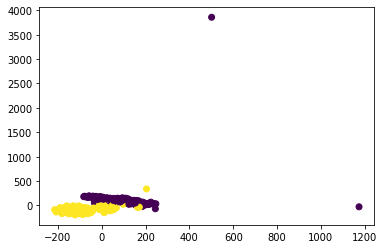

3


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


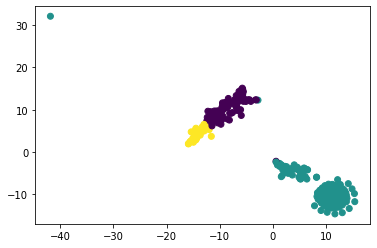

4


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


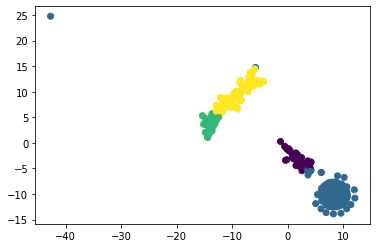

5


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


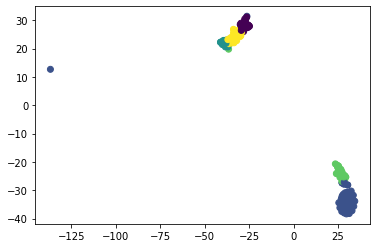

6


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


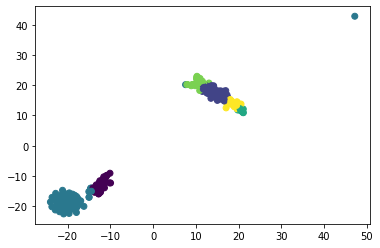

7


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


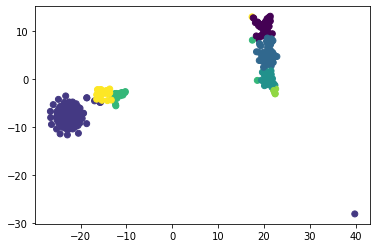

8


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


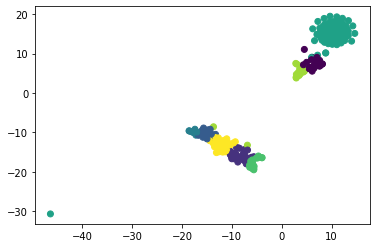

9


L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


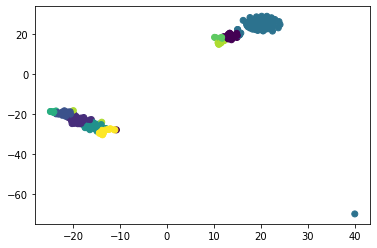

In [299]:
for n in range(2,10):
    print(n)
    make_clusters(X, n)

L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
L:\Users\nectostr\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


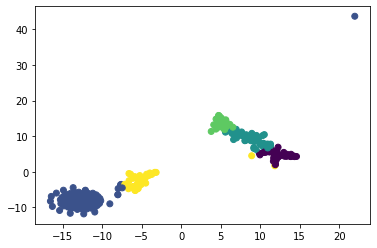

In [300]:
y = make_clusters(X, 5)

In [301]:
target["clusters"] = y

In [302]:
current.columns

Index(['week2_quiz', 'week3_quiz', 'week4_quiz', 'week6_quiz', 'week7_quiz',
       'week2_text', 'LA02 (Real)', 'week3_text', 'LA03 (Real)', 'week4_text',
       'LA04 (Real)', 'week5_text', 'LA05 (Real)', 'week6_text',
       'LA06 (combined) total (Real)', 'week7_text', 'LA07 (Real)',
       'week8_text', 'LA08 total (Real)', 'week2_embeding', 'week2_santiment',
       'week3_embeding', 'week3_santiment', 'clusters'],
      dtype='object')

In [303]:
for clus in np.unique(y):
    current = target[target["clusters"] == clus]
    print(f"Clus {clus}, len {len(current)}")
    # for i in current["week3_text"]:
    #     print("-", i)
    # print("\n")
    current.loc[current["LA03 (Real)"] == "-","LA03 (Real)"] = 0
    las = [float(i) for i in current["LA03 (Real)"]]
    qi = [float(i) for i in current["week3_quiz"]]
    sant = np.array([np.array(i) for i in current["week3_santiment"]])
    print("LAs", np.mean(las), np.median(las), np.min(las))
    print("Qs", np.mean(qi), np.median(qi), np.min(qi))
    print("Sant", np.mean(sant, axis=0), np.median(sant, axis=0), np.min(sant, axis=0))
    # print(las)
        

Clus 0, len 39
LAs 89.81923076923077 100.0 0.0
Qs 9.076923076923077 10.0 0.0
Sant [0.7810041  0.19906083 0.01993514] [0.7821185  0.19613211 0.01982073] [0.5541326  0.04178615 0.00412807]
Clus 1, len 111
LAs 78.64333333333333 100.0 0.0
Qs 8.297297297297296 10.0 0.0
Sant [0.22105472 0.5561007  0.22284374] [0.22382927 0.5498368  0.22633386] [0.15068793 0.5068831  0.13350299]
Clus 2, len 55
LAs 93.9570909090909 100.0 29.41
Qs 9.6 10.0 0.0
Sant [0.48044568 0.4252747  0.09427943] [0.49205735 0.43785116 0.08030234] [0.16016823 0.24801217 0.03249913]
Clus 3, len 34
LAs 87.88941176470587 100.0 0.0
Qs 9.588235294117647 10.0 0.0
Sant [0.06102584 0.33844155 0.60053253] [0.05372562 0.37216687 0.54293233] [0.00116439 0.00945985 0.28342286]
Clus 4, len 43
LAs 88.44093023255815 100.0 0.0
Qs 9.534883720930232 10.0 0.0
Sant [0.13264659 0.7585183  0.10883512] [0.11221241 0.7894666  0.09821445] [0.02775623 0.31495428 0.03388234]


In [305]:
for i in target.loc[target["clusters"] == 0,"week3_text"]:
    print("-", i)
print("\n")

-  The most challenging lab for me was 3.15. I believe my code is very close to being accurate, but I still do not know what's wrong so Im going to attend office hours this week. I think that I got something about the syntax of adding and indexing strings wrong.  Nope!
-  I had a hard time with the break out room custom dicionary activity. I didn't fully understand the instructions and what the output should look like. I sort of ended up giving up  
-  actually use the different types when writing a function. And writing function in general can still be a little confusing.  
-  I think tupels and dictionaries were definitely difficult at first as well as indexing even though it was quite a simple topic. It's just a different kind of formula that I wasn't really used to using that I need to practice more.  
-  Combining functions with dictionaries. One of the labs we had to call a dictionary in a function and I ran into a problem where I just couldn’t figure out how to combine the 2. I 